# <font color='blue'>**LABORATORIO 1. Comparación de clasificadores clásico y modernos**

<font color='red'>Integrantes: 
    
    Sebastian Amilkar Murillo 
    Mílmax Jeffrey Duque



Adicione el código que sea necesario. No olvide comentarlo.

In [ ]:
#coloque aqui todas las librerías que usará para desarrolar este laboratorio.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import tqdm
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns 

path='D:\python\lab'
os.chdir(path)
print(os.getcwd())
print(os.listdir())

c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\python\lab
['CVwDL_2022_3_Laboratorio1.ipynb', 'test', 'train']


## <font color='blue'>**(30%) Parte 1. Mejorando su clasificador clásico.**

En aula hemos creado un clasificador de zapatos haciendo uso de diferentes tipos de features (SIFT, SURF, ORB) que son agrupadas a través del uso de un BoVW el cual genera un arreglo 1D, usada como entrada a una ANN que se encarga finalmente de la clasificación de 3 tipos de objetos.
Sin embargo el accuracy no supera el 55%. 

Utilice técnicas que usted conozca ( o investigue) que le permitan mejorar el accuracy hasta al menos un 80%. Usted puede hacer uso de cualquier técnica siempre y cuando, explique en que consiste y como logró parametrizarla para mejorar su resultado.



In [ ]:
#Coloque su código aquí
for dirname, _, filenames in os.walk('train'):
  for filename in filenames:
    print(os.path.join(dirname,filename))
    break

tags = os.listdir('train')
print(tags)

train\adidas\100.jpg
train\converse\100.jpg
train\nike\100.jpg
['adidas', 'converse', 'nike']


In [ ]:
images = []
labels = []
for category in tags:
  print("leyendo categorias", category)
  class_num = tags.index(category) #cada una de las categorias esta asociada a un indice, para luego porder unirlo a un nombre
  route = os.path.join('train',category)
  for img in tqdm(os.listdir(route)):
    img_array = cv2.imread(os.path.join(route,img),cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array,(400,400))
    images.append(new_array)
    labels.append(class_num)

leyendo categorias adidas


100%|██████████| 237/237 [00:01<00:00, 139.17it/s]


leyendo categorias converse


100%|██████████| 237/237 [00:01<00:00, 143.79it/s]


leyendo categorias nike


100%|██████████| 237/237 [00:01<00:00, 145.81it/s]


In [ ]:
x_train = np.array(images)
y_train = np.array(labels)

x_train.shape

(711, 400, 400)

In [ ]:
images = []
labels = []
for category in tags:
  print("leyendo categorias", category)
  class_num = tags.index(category) #cada una de las categorias esta asociada a un indice, para luego porder unirlo a un nombre
  route = os.path.join('test',category)
  for img in tqdm(os.listdir(route)):
    img_array = cv2.imread(os.path.join(route,img),cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array,(400,400))
    images.append(new_array)
    labels.append(class_num)

leyendo categorias adidas


100%|██████████| 38/38 [00:00<00:00, 137.62it/s]


leyendo categorias converse


100%|██████████| 38/38 [00:00<00:00, 101.34it/s]


leyendo categorias nike


100%|██████████| 38/38 [00:00<00:00, 104.11it/s]


In [ ]:
x_test = np.array(images)
y_test = np.array(labels)

x_test.shape

(114, 400, 400)

## Aqui comienza nuestro tratamiento de imagenes

In [ ]:
#creando un diccionario guardando todas las imagenes con su correspondiente indice
images = {}

def loadImages(folder):
  for filename in os.listdir(folder):
    category = []
    route = folder + "/" + filename
    for cat in os.listdir(route):
      img = cv2.imread(route + "/" + cat, cv2.IMREAD_GRAYSCALE)
      if img is not None:
        category.append(img)
    images[filename] = category
  return images 

In [ ]:
train = loadImages('train')

In [ ]:
#funcion para hallar descriptores

def sift_features(images):
  sift_vector = {}
  descriptor_list = []
  sift = cv2.SIFT_create()
  for key,value in images.items():
    feactures = []
    for img in value:
      kp,desc=sift.detectAndCompute(img, None)
      descriptor_list.extend(desc)
      feactures.append(desc)
    sift_vector[key] = feactures
  return[descriptor_list,sift_vector]

In [ ]:
sifts = sift_features(train)
descriptor_list = sifts[0]
train_bovw_feat = sifts[1]

In [ ]:

from sklearn.cluster import KMeans

In [ ]:
def kmeans(k,descriptor_list):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(descriptor_list)
  visual_words = kmeans.cluster_centers_
  return visual_words

In [ ]:
visual_words = kmeans(200,descriptor_list)

In [ ]:
from scipy.spatial import distance
def find_index(image,center):
  count = 0
  index = 0
  for i in range(len(center)):
    if(i==0):
      count = distance.euclidean(image,center[i])
    else :
      dist = distance.euclidean(image,center[i])
      if (dist < count):
        index = i
        count = dist
  return index

In [ ]:
def img_class (bovw,centers):
  dict_feat = {}
  for key,value in bovw.items():
    category = []
    for img in value:
      hist = np.zeros(len(centers))
      for each_feacture in img:
        index = find_index(each_feacture,centers)
        hist[index] += 1
      category.append(hist)
    dict_feat[key] = category
  return dict_feat

In [ ]:
bovw_train = img_class(train_bovw_feat,visual_words)

In [ ]:
def prepare_data(dict):
  y=[]
  x=[]
  for key,values in dict.items():
    for img in values:
      x.append(img)
      y.append(key)
  return np.array(x), np.array(y)

In [ ]:
x_train,y_train = prepare_data(bovw_train)
print(x_train.shape)
print(y_train.shape)

(711, 200)
(711,)


In [ ]:
test = loadImages('test')

In [ ]:
test_bovw_feat = sift_features(test)[1]

In [ ]:
bovw_test = img_class(test_bovw_feat,visual_words)

In [ ]:
x_test,y_test = prepare_data(bovw_test)
print(x_test.shape)
print(y_test.shape)

(114, 200)
(114,)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

In [ ]:
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns

mlp = MLPClassifier(hidden_layer_sizes=(100,20), activation='relu',solver='adam',alpha=0.0001, random_state=1, max_iter=300, early_stopping=False, learning_rate='constant', momentum=0.9, )
mlp.fit(x_train,y_train)
p = mlp.predict(x_test)
acc = accuracy_score(y_test,p)
cf_matrix = confusion_matrix(y_test, p)
print('El accuracy de nuestra de red es:',str(acc))

El accuracy de nuestra de red es: 0.6052631578947368


# <font color='blue'>**(50%) Parte 2. Entrenando 3 arquitecturas CNN con Deep Learning**

Existen muchas arquitecturas basadas en deep Learning para crear clasificadores.
Usted deberá montar ("from scratch") y entrenar las siguientes 3 arquitecturas (para el dataset de zapatos):

LeNet

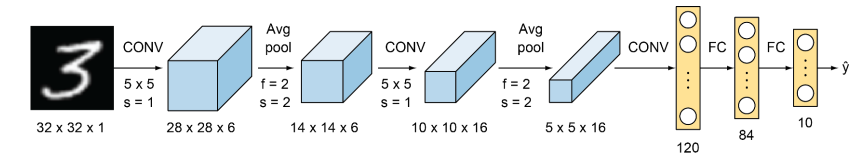

AlexNet

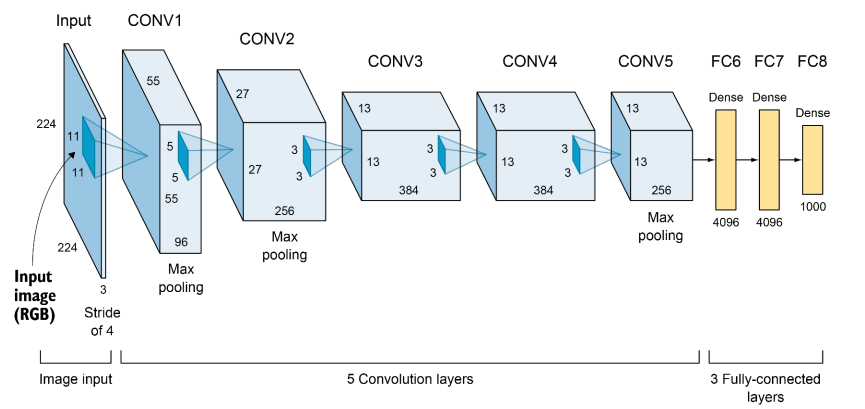

VGG16

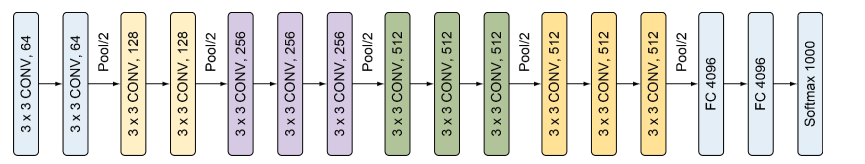

## Load data and pre-processing dataset

In [ ]:
train_images = []
train_labels = []
for category in tags:
  print("leyendo categorias", category)
  class_num = tags.index(category) #cada una de las categorias esta asociada a un indice, para luego porder unirlo a un nombre
  route = os.path.join('train',category)
  for img in tqdm(os.listdir(route)):
    img_array = cv2.imread(os.path.join(route,img))
    new_array = cv2.resize(img_array,(224,224))
    train_images.append(new_array)
    train_labels.append(class_num)

leyendo categorias adidas


100%|██████████| 237/237 [00:00<00:00, 834.51it/s]


leyendo categorias converse


100%|██████████| 237/237 [00:00<00:00, 896.61it/s]


leyendo categorias nike


100%|██████████| 237/237 [00:00<00:00, 909.89it/s]


In [ ]:
x_train = np.array(train_images)
y_train = np.array(train_labels)

print(x_train.shape)

(711, 224, 224, 3)


In [ ]:
test_images = []
test_labels = []
for category in tags:
  print("leyendo categorias", category)
  class_num = tags.index(category) #cada una de las categorias esta asociada a un indice, para luego porder unirlo a un nombre
  route = os.path.join('test',category)
  for img in tqdm(os.listdir(route)):
    img_array = cv2.imread(os.path.join(route,img))
    new_array = cv2.resize(img_array,(224,224))
    test_images.append(new_array)
    test_labels.append(class_num)

leyendo categorias adidas


100%|██████████| 38/38 [00:00<00:00, 699.77it/s]


leyendo categorias converse


100%|██████████| 38/38 [00:00<00:00, 717.00it/s]


leyendo categorias nike


100%|██████████| 38/38 [00:00<00:00, 635.53it/s]


In [ ]:
x_test = np.array(test_images)
y_test = np.array(test_labels)

x_test.shape

(114, 224, 224, 3)

In [ ]:
def preprocess_data(x_train, y_train, x_test, y_test):
  
  # convert image values from integers to floats
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  
  # normalization
  x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
  X_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
  
  # One-hot encoding label 
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  
  return x_train, y_train, x_test, y_test

In [ ]:
def summary_history(history):
  # plot loss
	plt.subplot(211)
	plt.title('Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='red', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='red', label='test')
	plt.show()

In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, epochs = 50, batch_size = 128):
   # Rescaling all training and testing data
  x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)

  # Implement data augmentation
  datagen = ImageDataGenerator(horizontal_flip=True, zoom_range=0.1, rotation_range=0.2)
  it_train = datagen.flow(x_train, y_train, batch_size= batch_size)
  steps = int(x_train.shape[0] / batch_size)
  
  # Fitting the model on the training set
  history = model.fit(it_train, epochs = epochs, batch_size = batch_size,validation_data = (x_test, y_test), steps_per_epoch=steps, verbose = 1)
  # evaluating the model
  _, acc = model.evaluate(x_test, y_test, verbose = 1)
  print('accuracy: %.3f' % (acc * 100.0))
  summary_history(history)

## LeNet

In [ ]:
def LeNet():
  model = Sequential()
  
  # Convolutional layer  
  model.add(Conv2D(filters = 6, kernel_size = (5,5), padding = 'valid', 
                   activation = 'relu', input_shape = (224,224,3)))
  
  # Max-pooing layer with pooling window size is 2x2
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  # Convolutional layer 
  model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = 'relu'))
  
  # Max-pooling layer 
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  # Flatten layer 
  model.add(Flatten())
  
  # The first fully connected layer 
  model.add(Dense(120, activation = 'relu'))

  # The second fully connected layer  
  model.add(Dense(80, activation = 'relu'))

  # The output layer  
  model.add(Dense(3, activation = 'softmax'))   
  
  model.compile(loss = "categorical_crossentropy", 
                optimizer = "adam", 
                metrics = ['accuracy']) 
                
  return model


In [ ]:
leNet_model = LeNet()
leNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 44944)             0         
                                                                 
 dense (Dense)               (None, 120)               5

## AlexNet

In [ ]:
def AlexNet():
  model = Sequential()
  
  # 1 Convolutional layer  
  model.add(Conv2D(filters = 96, kernel_size = (11,11), padding = 'valid', 
                   activation = 'relu',strides=(4,4), input_shape = (224,224,3),))
              
  
  
  # Max-pooing layer with pooling window size is 2x2
  model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = 'same'))
  
  #2 Convolutional layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), activation = 'relu', strides=(1,1), padding = 'same'))
  
  

  # Max-pooling layer 
  model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2), padding = 'same'))

  #3 Convolutional layer 
  model.add(Conv2D(filters = 384, kernel_size = (3,3), activation = 'relu', strides=(1,1), padding = 'same'))
  
  

  #4 Convolutional layer 
  model.add(Conv2D(filters = 384, kernel_size = (3,3), activation = 'relu', strides=(1,1), padding = 'same'))
  
  

  #5 Convolutional layer 
  model.add(Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', strides=(1,1), padding = 'same'))
  
  

  # Max-pooling layer 
  model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2), padding = 'same'))
  
  # Flatten layer 
  model.add(Flatten())
  
  # The first fully connected layer 
  model.add(Dense(4096, activation = 'relu',))

  

  # The second fully connected layer  
  model.add(Dense(4096, activation = 'relu',))

  

  
  # The third fully connected layer  
  model.add(Dense(1000, activation = 'relu',))

  
  

  # The output layer  
  model.add(Dense(3, activation = 'softmax'))   
  

  model.compile(loss = "categorical_crossentropy", 
                optimizer = "adam", 
                metrics = ['accuracy']) 
                
  return model

In [ ]:
AlexNet_model = AlexNet()
AlexNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 384)       885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 384)      

## VGG16

In [ ]:
def VGG16():
  
  model = Sequential()

  # 1 Convolutional layer
  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', 
                    activation = 'relu',strides=(4,4), input_shape = (224,224,3),))
  # 2 Convolutional layer
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

  # Max-pooling layer
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # 3 Convolutional layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

  # 4 Convolutional layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

  # Max-pooling layer
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # 5 Convolutional layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

  # 6 Convolutional layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

  # 7 Convolutional layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

  # Max-pooling layer
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # 8 Convolutional layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

  # 9 Convolutional layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

  # 10 Convolutional layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

  # Max-pooling layer
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # 11 Convolutional layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

  # 12 Convolutional layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

  # 13 Convolutional layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

  # Max-pooling layer
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # Flatten layer 
  model.add(Flatten())
    
  # The first fully connected layer 
  model.add(Dense(4096, activation = 'relu',))

  # The second fully connected layer  
  model.add(Dense(4096, activation = 'relu',)) 

  # The output layer  
  model.add(Dense(3, activation = 'softmax'))   
    
  model.compile(loss = "categorical_crossentropy", 
                  optimizer = "adam", 
                  metrics = ['accuracy']) 
                  
  return model


In [ ]:
VGG_model = VGG16()
VGG_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                  

## Training models

Al final de cada entrenamiento se observa las gráficas con el accuracy y el loss.

Epoch 1/50
5/5 [==============================] - 7s 1s/step - loss: 0.5673 - accuracy: 0.7616 - val_loss: 536.2677 - val_accuracy: 0.4561
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.5829 - accuracy: 0.7633 - val_loss: 340.3497 - val_accuracy: 0.5175
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.5089 - accuracy: 0.7942 - val_loss: 452.2573 - val_accuracy: 0.4298
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.4649 - accuracy: 0.8165 - val_loss: 546.9445 - val_accuracy: 0.4561
Epoch 5/50
5/5 [==============================] - 7s 1s/step - loss: 0.4093 - accuracy: 0.8359 - val_loss: 564.3629 - val_accuracy: 0.4649
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.3747 - accuracy: 0.8662 - val_loss: 510.0408 - val_accuracy: 0.4912
Epoch 7/50
5/5 [==============================] - 7s 1s/step - loss: 0.3405 - accuracy: 0.8696 - val_loss: 663.8439 - val_accuracy: 0.4474
Epoch 8/50
5/5 [===========

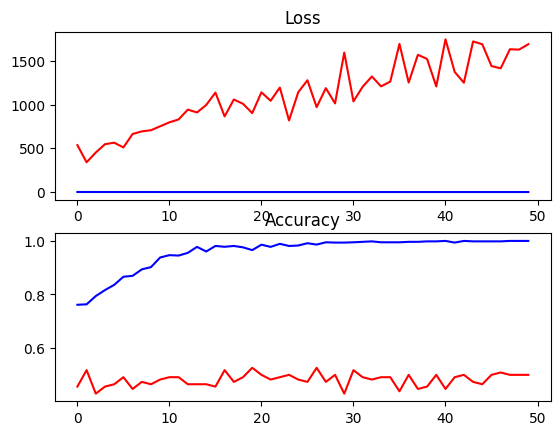

In [ ]:
train_model (leNet_model, x_train, y_train, x_test, y_test)

Epoch 1/50
5/5 [==============================] - 19s 4s/step - loss: 1.0989 - accuracy: 0.3328 - val_loss: 2.1313 - val_accuracy: 0.3421
Epoch 2/50
5/5 [==============================] - 21s 4s/step - loss: 1.0990 - accuracy: 0.3276 - val_loss: 3.0808 - val_accuracy: 0.3333
Epoch 3/50
5/5 [==============================] - 21s 4s/step - loss: 1.1157 - accuracy: 0.3636 - val_loss: 5.0933 - val_accuracy: 0.3509
Epoch 4/50
5/5 [==============================] - 20s 4s/step - loss: 1.0970 - accuracy: 0.3705 - val_loss: 17.7411 - val_accuracy: 0.3333
Epoch 5/50
5/5 [==============================] - 21s 4s/step - loss: 1.0986 - accuracy: 0.3396 - val_loss: 26.1080 - val_accuracy: 0.3333
Epoch 6/50
5/5 [==============================] - 67s 13s/step - loss: 1.1013 - accuracy: 0.3259 - val_loss: 4.8562 - val_accuracy: 0.3333
Epoch 7/50
5/5 [==============================] - 36s 5s/step - loss: 1.0976 - accuracy: 0.3671 - val_loss: 5.4788 - val_accuracy: 0.3333
Epoch 8/50
5/5 [===============

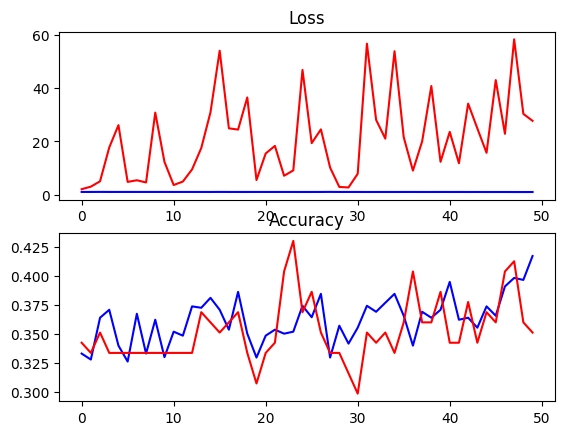

In [ ]:
train_model (AlexNet_model, x_train, y_train, x_test, y_test)

Epoch 1/50
5/5 [==============================] - 27s 6s/step - loss: 1.1011 - accuracy: 0.3276 - val_loss: 1.1028 - val_accuracy: 0.3333
Epoch 2/50
5/5 [==============================] - 23s 5s/step - loss: 1.0987 - accuracy: 0.3310 - val_loss: 1.1027 - val_accuracy: 0.3684
Epoch 3/50
5/5 [==============================] - 22s 4s/step - loss: 1.0999 - accuracy: 0.3310 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 4/50
5/5 [==============================] - 22s 4s/step - loss: 1.0986 - accuracy: 0.3465 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 5/50
5/5 [==============================] - 23s 4s/step - loss: 1.0989 - accuracy: 0.3396 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/50
5/5 [==============================] - 22s 4s/step - loss: 1.0983 - accuracy: 0.3482 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 7/50
5/5 [==============================] - 22s 4s/step - loss: 1.0988 - accuracy: 0.3293 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 8/50
5/5 [==================

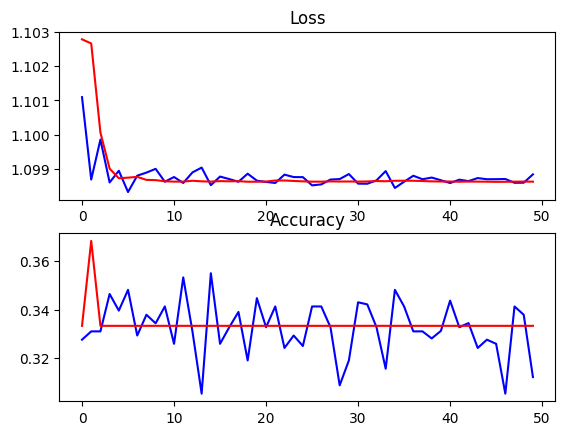

In [ ]:
train_model(VGG_model, x_train, y_train, x_test, y_test)

## <font color='blue'>**(20%) Parte 3. Usando *Accuracy*, *Loss* y *Confusion* *Matrix* para comparar el *performance* de sus modelos**

Utilice las curvas de Loss , Accuracy y la matriz de confusión, para realizar  una tabla comparativa de los resultados obtenidos haciendo uso de los diferentes modelos previamente entrenados. Escriba al menos 3 conclusiones acerca de las técnicas aqui usadas que permitan conocer las "bondades" y los "defectos" de dichas técnicas.

In [ ]:
def cf_matrix(model,name):
  predic =model.predict(x_test)
  cm = confusion_matrix(y_test, predic.argmax(1))
  name = name
  plt.figure(figsize=(8,6))
  plt.title(name)
  sns.heatmap(cm, annot=True, fmt='g')
  plt.xticks(np.arange(cm.shape[0]), ['Adidas', 'Converse', 'Nike'], rotation=90)
  plt.yticks(np.arange(cm.shape[0]), ['Adidas', 'Converse', 'Nike'], rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

4/4 [==============================] - 0s 48ms/step


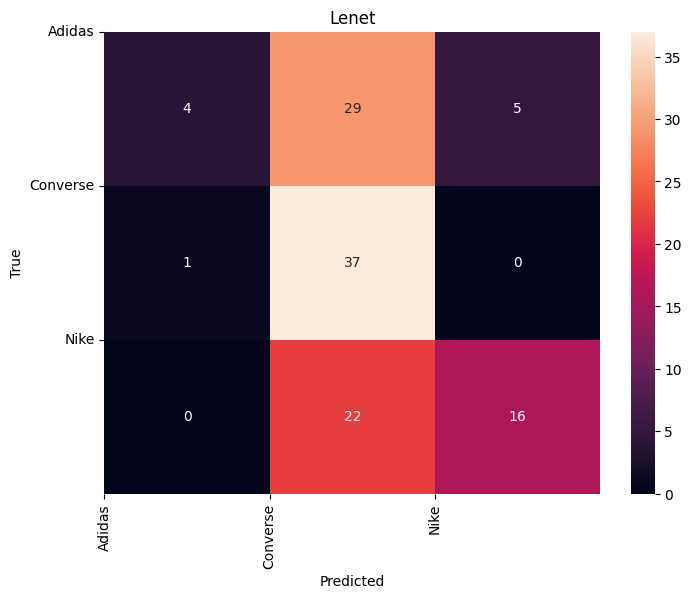

In [ ]:
cf_matrix(leNet_model,"Lenet")

4/4 [==============================] - 1s 168ms/step


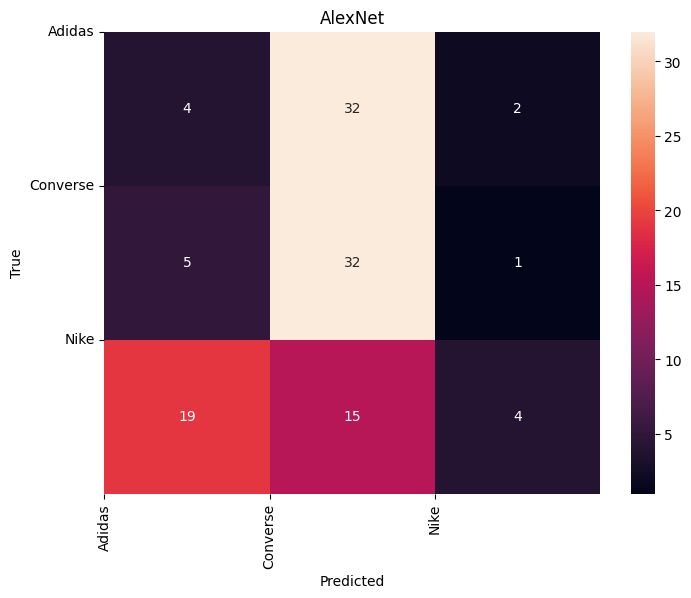

In [ ]:
cf_matrix(AlexNet_model,"AlexNet")

4/4 [==============================] - 1s 136ms/step


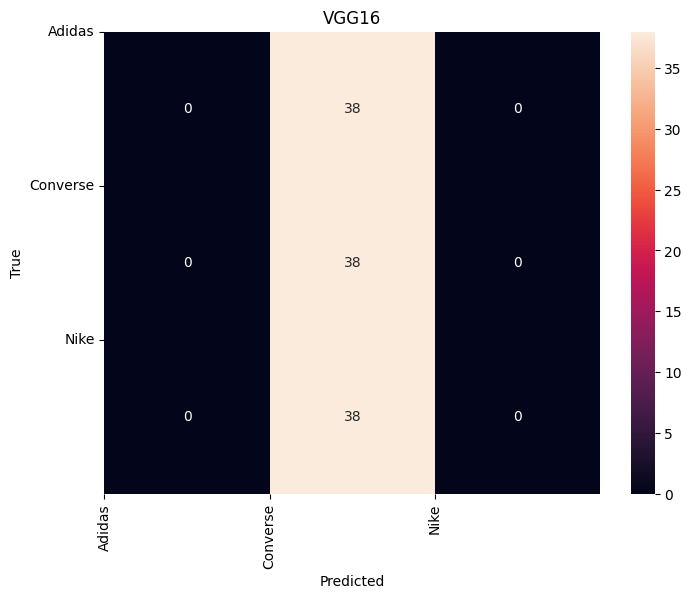

In [ ]:
cf_matrix(VGG_model,"VGG16")

## Conclusiones


Bovw

La idea general de la bolsa de palabras visuales (BOVW) es representar una imagen como un conjunto de características. Éstas consisten en puntos clave (regiones) y descriptores (de estas regiones). Los puntos clave son las regiones claves de una imagen, por lo que no importa si la imagen se gira, se reduce o se expande, sus puntos clave siempre serán los mismos. Y descriptor es la descripción del punto clave. Usamos los puntos clave y los descriptores para construir vocabularios y representar cada imagen como un histograma de frecuencia de características que están en la imagen. A partir del histograma de frecuencias, más adelante, podemos encontrar otras imágenes similares o predecir la categoría de la imagen. 

Observaciones



*   Utilizamos una MLP la cual obtuvo un accuracy del 60%, sin embargo, se identifica que el dataset es pequeño. Y con los resultados arrojados es posible que los datos no sean completamente representativos. Y el dataaumentation, solo generará un problema y es que la creación del bovw (kmenas) solo sirve con conjunto de datos pequeños. Por ende, este método sería ideal. Combinarlo con otras técnicas.

Alternativa


*   1) Elegir un método alterno para generar la bolsa de palabras visuales, dentro de los existentes, estos consumen una mayor cantidad de RAM, así que se generarían nuevos requisitos. 2) Transferlearning para la clasificación. 3) Métodos de machine learning clásicos menos complejos.








---


La arquitectura LeNet obtuvo mejor resultado que las redes VGG16 y AlexNet, con un accuracy del 50%. Sin embargo, se observará como a medida que la red es más profunda, el contar un conjunto bajo de datos influirá negativamente en su desempeño, además de otros factores de arquitectura que se tratan.

*  LeNet, el acuraccy en este entrenamiento es pésimo, aunque fue el mayor. Y se considera que este resultado se debe a su arquitectura tal como presenta Yann LeCun en 1998 para reconocer patrones visuales directamente a partir de imágenes de píxeles con un preprocesamiento mínimo. Lo anterior explica el porqué con básicas transformaciones al dataset  pudo lograr un mejor desempeño.
Sin embargo, como bien lo manifiesta el creador, es especial para  reconocer patrones con una variabilidad extrema (como caracteres escritos a mano) y con solidez a las distorsiones y transformaciones geométricas simples. Lo anterior le ha dado un accuracy superior al 98% con respecto a  CNN tradicionales, en la predicción del MNIST. Adicionalmente, se le observa como sus caracterísitcas para extracción de características no son lo suficientemente efectivas para este pequeño conjunto de datos.



*   Por último al observar el gráfico de loss/accuracy. Tenemos que la curva roja esta sobre el loss azul (entrenamiento). Continuamente aumentando el error, esto muestra lo poco representativo que es el dataset de entrenamiento para los datos. Y que por otro lado ( gráfico de accuracy) se ve como el modelo se va cada vez sobreentrenando, perdiendo la capacidad de generalizar. Esto debido a varios factores, 1) Pocos datos de entrenamiento 2) Baja representación del conjunto de datos 3) Ruido 4) El modelo es muy complejo 5) Carencia de métodos de regularización.



Alternativa:

*   Se considera que el uso de data aumentation con transferlearning sea un buen punto de partida para hacer uso de esta red en este problema de clasificación.



---


 AlexNet, con un accuracy del 35%

*  AlexNet,  dicho en palabras de su crador,Alex Krizhevsky, es bastante similar a LeNet-5, solo que mucho más grande y profundo, y fue el primero en apilar capas convolucionales directamente una encima de la otra, en lugar de apilando una pooling layer encima de cada capa convolucional. Y la parte más importante, es que debido a su arquitectura se vuelve mucho más compleja, hasta tal punto que según comentan los autores. 
Para reducir el sobreajuste, los autores utilizaron dos técnicas de regularización: 1)
dropout aplicado  con una tasa de abandono del 50% durante el entrenamiento
a las salidas de las capas F8 y F9. 2) realizaron el aumento de datos cambiando aleatoriamente las imágenes de entrenamiento en varios desplazamientos, volteándolas horizontalmente, y
cambiando las condiciones de iluminación. 3) Local Response Normalization




*   En este caso cambia la situación y obtenemos que en la gráfica de loss, la curva roja de datos de validación oscila demasiado, lo cual muestra que el modelo tiene problemas para generalizar. Por lo tanto como  comentamos anteriormente el conjunto de datos de validación no es representado fielmente por los datos de entrenamiento. Por otro lado, el caso que sucede con el gráfico de acuraccy es diferente. Las curvas de accuracy tiene un comportamiento oscilante en paralelo, teniendo como resultado un sub entrenamiento. En este caso, aunque tenemos un modelo demasiado complejo, no caemos en soobree entrenamiento. Simplemente, el conjunto de datos no es suficiente. Pero dado el problema anterior con la LeNet. Sería interesante ver los resultados, sin utilizar los métodos de regularización que plantea el autor y posteriormente con la regularización.
Siempre y cuando se solucione el primer inconveniente el cual es obtener un mejor conjunto de datos de entrenamiento.



Alternativa
*   Combinar técnicas con/sin normalización  combinandola con las estrategias anteriormente vistas hayando un equilibrio.


---


Vgg16 con un accuracy del 33,33%



*   VGG16, A medida que la red tiene mayor número de operaciones y se vuelve más profunda, mayor cantidad de operaciones son realizadas y más datos son necesarios . Como resultado, la red no generaliza, ni predice adecuadamente, en especial si no se cuentan con suficientes datos.

Alternativa
*   Combinar técnicas con/sin normalización  combinandola con las estrategias anteriormente vistas hayando un equilibrio.




Documentación de soporte. 
**Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems**


